## Generalized Polynomial Chaos

Generalized polynomial chaos is an advanced polynomial chaos method for dealing with problematic random variables.
The problems it deals with include heavy tailed distributions (like Log-lormal, Cauchy, etc.) which breaks premises for using chaos expansion as approximations, and stochastic dependencies, which there currently does not exist numerically stable method for creating.
Let us consider an synthetic exponential model than encompases both issues by using a multivariate log-normal distribution for its uncertainty:

In [1]:
import numpy
import chaospy

coordinates = numpy.linspace(0, 10, 1000)

def exponential_model(parameters):
    param_init, param_rate = parameters
    return param_init*numpy.e**(-param_rate*coordinates)

distribution = chaospy.MvNormal(mu=[10, 1], sigma=[[1.0, 0.09], [0.09, 0.1]])

We are interested in the mean and standard deviation.

### Monte Carlo integration

As a baseline we can solve this using quasi-Monte Carlo integration. It requires no modification compared to the stochastic independent case. It consists of generating samples:

In [2]:
samples = distribution.sample(10**5, rule="sobol")

evaluate model for each sample:

In [3]:
evaluations = numpy.array([exponential_model(sample) for sample in samples.T])

and performing analysis on samples:

In [4]:
# NBVAL_CHECK_OUTPUT
mean = numpy.mean(evaluations, axis=0)
std = numpy.std(evaluations, axis=0)

(mean[:5].round(5), std[:5].round(5))

(array([9.99998, 9.89953, 9.8002 , 9.70195, 9.60479]),
 array([0.9999 , 0.9815 , 0.96431, 0.94833, 0.93353]))

We can also plot the final result:

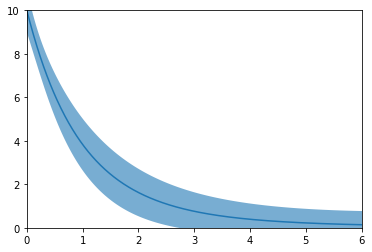

In [5]:
from matplotlib import pyplot

pyplot.fill_between(coordinates, mean-std, mean+std, alpha=0.6)
pyplot.plot(coordinates, mean)

pyplot.axis([0, 6, 0, 10])

pyplot.show()

### Generalized polynomial chaos

Polynomial chaos expansions builds on the assumption of having an orthogonal polynomial expansion. However, the classical extension to the multivariate case assumes that the probabilty distribution consist of stochastically independent components. If the distribution has dependencies, the classical approach will not work.

The recommended approach for addressing dependent distribution is to use *generalized polynomial chaos expansion* (g-pce). It assumes that there exists a smooth map $T$ between the dependent variables $Q$ and some other stochastic independent variables $R$, which we can build an expansion for. In other words:

$$
\hat u(x, q) = \hat u(x, T(r)) = \sum_{n=0}^N c_n \Phi_n(r)
$$

For multivariate normal distributions, the obvious choice is to select $R$ to be standard normal:

In [6]:
distribution_q = distribution
distribution_r = chaospy.J(chaospy.Normal(0, 1), chaospy.Normal(0, 1))

The $T$ is defined as a double Rosenblatt transformation:

$$
T(r) = F_Q^{-1}\left( F_R(r) \right)
$$

which in `chaospy` can be constructed as follows:

In [7]:
def transform(samples):
    return distribution_q.inv(distribution_r.fwd(samples))

This formulation is general and can be used with any two distributions of the same size.

### Point collocation method

Implementing g-pce for point collocation require us to generate samples from $R$ and transform them using $T$:

In [8]:
samples_r = distribution_r.sample(1000, rule="sobol")
samples_q = transform(samples_r)

The resluting samples can then be used to solve the equation above using regression-based method:

In [9]:
expansion = chaospy.generate_expansion(7, distribution_r)
evaluations = numpy.array([exponential_model(sample) for sample in samples_q.T])
model_approx = chaospy.fit_regression(expansion, samples_r, evaluations)

Note that for generating the expansion and the model approximation, we use the distribution from $R$, while for the model evalutation we use the transformed samples from $Q$.

The solution model can then be used to do analysis. Just remember that the model is defined with respect to $R$ , not $Q$:

In [10]:
# NBVAL_CHECK_OUTPUT
mean = chaospy.E(model_approx, distribution_r)
std = chaospy.Std(model_approx, distribution_r)

(mean[:5].round(5), std[:5].round(5))

(array([10.     ,  9.89956,  9.80022,  9.70198,  9.60482]),
 array([1.     , 0.98159, 0.9644 , 0.94841, 0.93361]))

Plotting the final results:

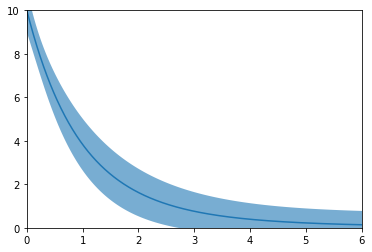

In [11]:
pyplot.fill_between(coordinates, mean-std, mean+std, alpha=0.6)
pyplot.plot(coordinates, mean)

pyplot.axis([0, 6, 0, 10])

pyplot.show()

### Pseudo-Spectral Projection

Implementing g-pce for pseudo-spectral projection require us to generate nodes and weights from $R$ and transform the nodes using $T$:

In [12]:
nodes_r, weights_r = chaospy.generate_quadrature(10, distribution_r, rule="gaussian")
nodes_q = transform(nodes_r)

The resluting samples can then be used to solve the equation above using the quadrature-based method:

In [13]:
expansion = chaospy.generate_expansion(7, distribution_r)
evaluations = numpy.array([exponential_model(sample) for sample in nodes_q.T])
model_approx = chaospy.fit_quadrature(expansion, nodes_r, weights_r, evaluations)

Note that for generating the expansion and the model approximation, we use the nodes and weights from $R$, while for the model evalutation we use the transformed samples from $Q$.

The solution model, defined with respect to $R$ can then be used to do analysis:

In [14]:
# NBVAL_CHECK_OUTPUT
mean = chaospy.E(model_approx, distribution_r)
std = chaospy.Std(model_approx, distribution_r)

(mean[:5].round(5), std[:5].round(5))

(array([10.     ,  9.89956,  9.80022,  9.70198,  9.60482]),
 array([1.     , 0.98159, 0.9644 , 0.94841, 0.93361]))

Plotting the final results:

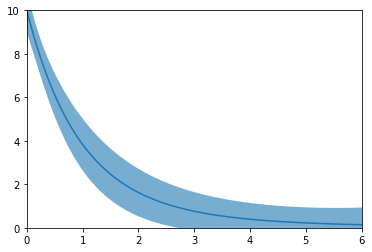

In [15]:
pyplot.fill_between(coordinates, mean-std, mean+std, alpha=0.6)
pyplot.plot(coordinates, mean)

pyplot.axis([0, 6, 0, 10])

pyplot.show()

### Cholesky decomposition

The assumption with generalized polynomial chaos expansion is that there exists a smooth mapping to a stochastic independent variable.
However, such a mapping does not always exists.
In those cases making an orthogonal expansion directly on the dependent variable using Cholesky decomposion.
This can be done as follows:

In [16]:
# NBVAL_CHECK_OUTPUT
expansion = chaospy.generate_expansion(5, distribution_q, rule="cholesky")
expansion[:5].round(10)

polynomial([1.0, q1-1.0, -0.9*q1+q0-9.1, q1**2-2.0*q1+0.9,
            -0.9*q1**2+q0*q1-8.2*q1-q0+9.1])

The method is known to be numerical unstable, so it is important to verify that the expansion is indeed orthogonal:

In [17]:
chaospy.Corr(expansion[-10:], distribution).round(5)

array([[ 1.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.],
       [-0.,  1.,  0., -0.,  0., -0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1., -0., -0.,  0.,  0., -0., -0.,  0.],
       [ 0.,  0., -0.,  1., -0.,  0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0.,  0.,  1.,  0., -0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0.,  0.,  0., -0.],
       [-0.,  0., -0.,  0.,  0., -0.,  1., -0., -0., -0.],
       [-0.,  0., -0., -0., -0., -0., -0.,  1.,  0.,  0.],
       [-0., -0.,  0.,  0., -0.,  0.,  0., -0.,  1.,  0.],
       [ 0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  1.]])

This expansion can be used with point colloction method directly:

In [18]:
samples_q = distribution_q.sample(1000, rule="sobol")
evaluations = numpy.array([exponential_model(sample) for sample in samples_q.T])
model_approx = chaospy.fit_regression(expansion, samples_q, evaluations)

In [19]:
# NBVAL_CHECK_OUTPUT
mean = chaospy.E(model_approx, distribution_q)
std = chaospy.Std(model_approx, distribution_q)

(mean[:5].round(5), std[:5].round(5))

(array([10.     ,  9.89956,  9.80022,  9.70198,  9.60482]),
 array([1.     , 0.98159, 0.9644 , 0.94841, 0.93361]))

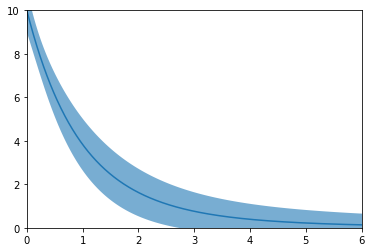

In [20]:
pyplot.fill_between(coordinates, mean-std, mean+std, alpha=0.6)
pyplot.plot(coordinates, mean)

pyplot.axis([0, 6, 0, 10])

pyplot.show()

For more details on this methodology, you can read the journal article
[Multivariate Polynomial Chaos Expansions with Dependent Variables](https://doi.org/10.1137/15M1020447).